## Dataset Description 

Billboard has published a Year-End Hot 100 every December since 1958. The chart measures the performance of singles in the U.S. throughout the year. Using R, I’ve combined the lyrics from 50 years of Billboard Year-End Hot 100 (1965-2015) into one dataset for analysis. You can download that dataset here.

The songs used for analysis were scraped from Wikipedia’s entry for each Billboard Year-End Hot 100 Songs (e.g., 2014). This is the year-end chart, not weekly rankings. Many artists have made the weekly chart but not the final year end chart. The final chart is calculated using an inverse point system based on the weekly Billboard charts (100 points for a week at number one, 1 point for a week at number 100, etc).

I used the xml and RCurl packages to scrape song and artist names from each Wikipedia entry. I then used that list to scrape lyrics from sites that had predictable URL strings (for example, metrolyrics.com uses metrolyrics.com/SONG-NAME-lyrics-ARTIST-NAME.html). If the first site scrape failed, I moved onto the second, and so on. About 78.9% of the lyrics were scraped from metrolyics.com, 15.7% from songlyrics.com, 1.8% from lyricsmode.com. About 3.6% (187/5100) were unavailable.

The dataset features 5100 observations with the features rank (1-100), song, artist, year, lyrics, and source. The artist feature is fairly standardized thanks to Wikipedia, but there is still quite a bit of noise when it comes to artist collaborations (Justin Timberlake featuring Timbaland, for example). If there were any errors in the lyrics that were scraped, such as spelling errors or derivatives like "nite" instead of "night," they haven't been corrected.

The above mentionned description comes from https://github.com/walkerkq/musiclyrics.

In [96]:
%matplotlib inline

import pickle
import random
import matplotlib
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [131]:
save_figures = False
fig_size = (18, 10) if save_figures else (12, 8)
font_size = 24 if save_figures else 16
graph_color = "white" if save_figures else "black"

def set_axis_color(ax, graph_color):
    ax.xaxis.label.set_color(graph_color)
    ax.tick_params(axis='x', colors=graph_color)
    ax.yaxis.label.set_color(graph_color)
    ax.tick_params(axis='y', colors=graph_color)
    ax.spines['bottom'].set_color(graph_color)
    ax.spines['top'].set_color(graph_color)
    ax.spines['left'].set_color(graph_color)
    ax.spines['right'].set_color(graph_color)

# Data analysis

### Lyrics Top-100 dataset

In [98]:
data_file = "datasets/songs/billboard_full.csv"
df_songs = pd.read_csv(data_file, index_col=0, header=0, sep=",")
df_songs["Lyrics"] = df_songs["Lyrics"].apply(lambda x: x.replace("\n", " "))
print("Dataframe contains {} unique artists.".format(len(df_songs["Artist"].unique())))
df.head(2)

Dataframe contains 2116 unique artists.


,Unnamed: 0.1,Rank,Song,Artist,Year,Lyrics,Genre,Album,Youtube,Entities,word_count,Entities_more
0,0,1,wooly bully,sam the sham and the pharaohs,1965,"Uno, dos One, two, tres, quatro Matty told Hat...",rock,wooly bully,https://www.youtube.com/watch?v=uE_MpQhgtQ8,"[(tres, GPE), (Matty, PERSON), (Hatty, PERSON)...",87,"[(tres, GPE, 19, 23), (Matty, PERSON, 32, 37),..."
1,1,2,i cant help myself sugar pie honey bunch,four tops,1965,"Uuh Sugar pie, honey bunch You know that I lov...",r&b soul,greatest hits in concert,https://www.youtube.com/watch?v=s3bksUSPB4c,"[(Love, WORK_OF_ART)]",271,"[(Love, WORK_OF_ART, 1201, 1205)]"


### Number of years in Top 100 per Song

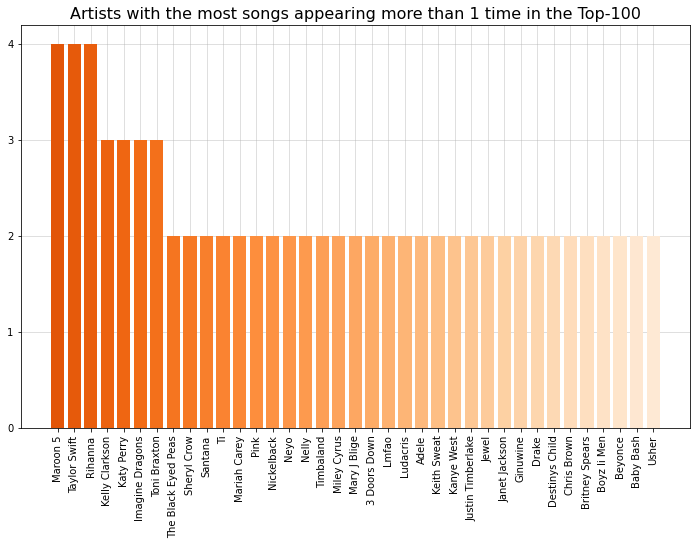

In [99]:
df_count = df_songs.groupby(["Artist", "Song"])["Year"].agg(list).to_frame()
df_count["Count"] = df_count.Year.apply(len)
df_count = df_count.sort_values("Count", ascending = False)
df_count = df_count[df_count["Count"] == 2].groupby("Artist").agg(list)
df_count["total"] = df_count["Count"].map(lambda x: len(x))
df_count = df_count[df_count["total"] >=2]
df_count = df_count.sort_values(by=["total"], ascending=False)

# Labels
labels = list(map(lambda x: " ".join(list(map(lambda y: y.capitalize(), x.split(" ")))), df_count.index))

# Colors
cmap = cm.get_cmap('Oranges_r')
colors = cmap(np.linspace(0.3, 0.9, len(df_count)))

# Title
title = "Artists with the most songs appearing more than 1 time in the Top-100"

# Plot
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)
plt.bar(labels, height=df_count["total"], color=colors, zorder=10)
plt.xticks(labels, rotation='vertical')
plt.yticks([0, 1, 2, 3, 4])
plt.title(title, color=graph_color, fontsize=font_size)
plt.grid(zorder=0, alpha=0.5)
plt.subplots_adjust(bottom=0.18)

# Axis color
set_axis_color(ax, graph_color)

# Save figure
if save_figures:
    plt.savefig('../images/data_analysis/{}.png'.format(title), dpi=300, transparent=True)
plt.show()

### Genre

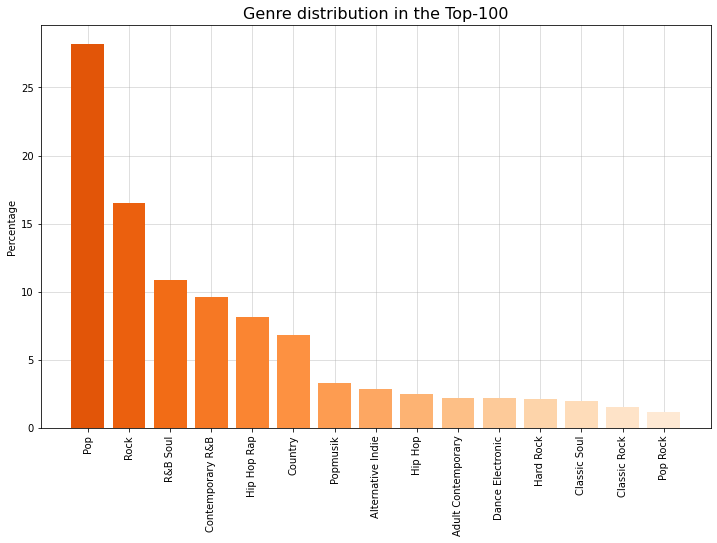

In [100]:
vc_genre = df_songs["Genre"].value_counts()

# Filter very unfrequent
vc_genre = vc_genre[vc_genre > 50] 
vc_genre = vc_genre.apply(lambda x: x / sum(vc_genre.values))

# Labels
labels = list(map(lambda x: " ".join(list(map(lambda y: y.capitalize(), x.split(" ")))), vc_genre.index))
labels = list(map(lambda x: " ".join(list(map(lambda y: "R&B" if y == "R&b" else y, x.split(" ")))), labels))

# Title
title = "Genre distribution in the Top-100"

# Plot
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)

# Colors
cmap = cm.get_cmap('Oranges_r')
colors = cmap(np.linspace(0.3, 0.9, len(vc_genre)))

# Plot
plt.bar(labels, height=vc_genre.map(lambda x: x*100), color=colors, zorder=10)
plt.xticks(labels, rotation='vertical')
plt.title(title, color=graph_color, fontsize=font_size)
plt.ylabel("Percentage")
plt.grid(zorder=0, alpha=0.5)
plt.subplots_adjust(bottom=0.18)

# Axis color
set_axis_color(ax, graph_color)

# Save plot
if save_figures:
    plt.savefig('../images/data_analysis/{}.png'.format(title), dpi=300, transparent=True)
plt.show()

### Number of songs in top 100 per artist (if a song is twice, is counted twice)

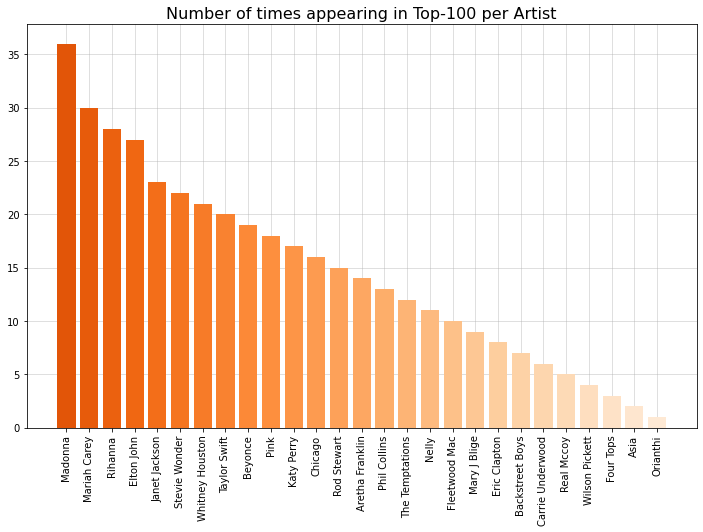

In [101]:
df_songCounts = df_songs[["Artist", "Song"]].groupby("Artist").agg(list).reset_index()
df_songCounts["Count"] = df_songCounts.Song.apply(len)

# As many artists might have the same number of songs in the Billboard (especially for small
# numbers), we pick an artist at random
df_songCounts = df_songCounts[["Artist", "Count"]]
df_songCounts = df_songCounts.groupby("Count").agg(list)
df_songCounts = df_songCounts["Artist"].apply(lambda x: x[random.randint(0, len(x) - 1)]).reset_index()
df_songCounts = df_songCounts.sort_values(by=["Count"], ascending=False)

artists = df_songCounts["Artist"].map(lambda x: " ".join(list(map(lambda y: y.capitalize(), x.split(" ")))))

# Color
cmap = cm.get_cmap('Oranges_r')
colors = cmap(np.linspace(0.3, 0.9, len(artists)))

# Title
title = "Number of times appearing in Top-100 per Artist"

# Plot
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)
plt.bar(artists, height=df_songCounts["Count"], color=colors, zorder=10)
plt.xticks(artists, rotation='vertical')
plt.title(title, color=graph_color, fontsize=font_size)
plt.grid(zorder=0, alpha=0.5)
plt.subplots_adjust(bottom=0.18)

# Axis color
set_axis_color(ax, graph_color)

# Save plot
if save_figures:
    plt.savefig('../images/data_analysis/{}.png'.format(title), dpi=300, transparent=True)
plt.show()

### Lyrics statistics

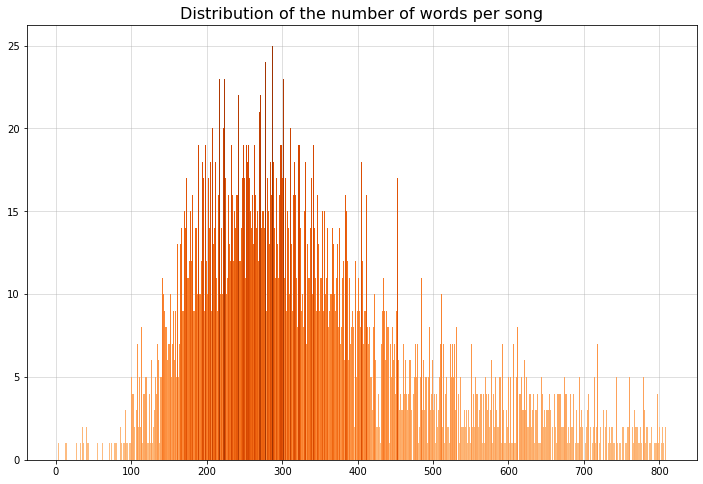

In [132]:
# Data for histograms
lyrics_lengths = df_songs["Lyrics"].apply(lambda s: len(s.split(" ")))
bins = range(2, len(lyrics_lengths.unique()))

# Title
title = "Distribution of the number of words per song"

# Plot
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(lyrics_lengths, bins=bins, zorder=10)
plt.title(title, color=graph_color, fontsize=font_size)
plt.grid(zorder=0, alpha=0.5)

# Colors
cmap = cm.get_cmap('Oranges')
cmap = cmap(np.linspace(0.3, 0.9, 100))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("my_colormap", cmap)        
for i in range(len(patches)):
    patches[i].set_facecolor(cmap(n[i]/max(n)))

# Axis color
set_axis_color(ax, graph_color)

# Save plot
if save_figures:
    plt.savefig('../images/data_analysis/{}.png'.format(title), dpi=300, transparent=True)
plt.show()

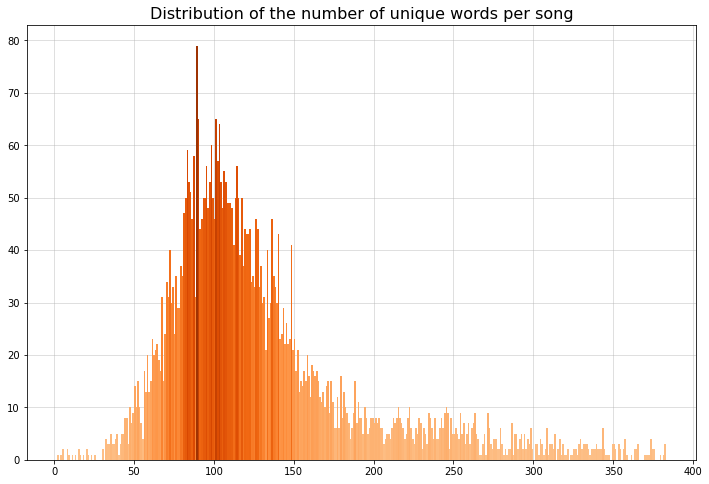

In [133]:
# Data for histograms
lyrics_lengths_unique = df_songs.Lyrics.apply(lambda s: len(set(s.split(" "))))
bins = range(2, len(lyrics_lengths_unique.unique()))

# Title
title = "Distribution of the number of unique words per song"

# Plot
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(lyrics_lengths_unique, bins=bins, zorder=10)
plt.title(title, color=graph_color, fontsize=font_size)
plt.grid(zorder=0, alpha=0.5)

# Colors
cmap = cm.get_cmap('Oranges')
cmap = cmap(np.linspace(0.3, 0.9, 100))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("my_colormap", cmap)        
for i in range(len(patches)):
    patches[i].set_facecolor(cmap(n[i]/max(n)))

# Axis color
set_axis_color(ax, graph_color)

# Save plot
if save_figures:
    plt.savefig('../images/data_analysis/{}.png'.format(title), dpi=300, transparent=True)
plt.show()

# Clusterisation of texts

In [104]:
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/franckdessimoz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/franckdessimoz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/franckdessimoz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [105]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize 
from sklearn.decomposition import TruncatedSVD
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

In [106]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

In [107]:
def lemmatize(token, pos_tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(pos_tag[0], wn.NOUN)
    return lemmatizer.lemmatize(token, tag)

In [108]:
def preprocess_lyrics(lyrics):
    tagged_tokens = pos_tag(wordpunct_tokenize(lyrics))
    preprocessed = [lemmatize(token, tag) for (token, tag) in tagged_tokens if not token in stop_words]
    return " ".join(preprocessed)

In [109]:
# Fill NA values
preprocessed_lyrics = df_songs["Lyrics"].fillna("").apply(preprocess_lyrics)

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english', preprocessor=None)

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(preprocessed_lyrics)

In [110]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1: -1]]))

In [111]:
# Tweak the two parameters below
number_topics = 5
number_words = 4

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
oh ooh yeah baby

Topic #1:
na shake like stop

Topic #2:
love know baby say

Topic #3:
want yeah man turn

Topic #4:
like know girl yeah


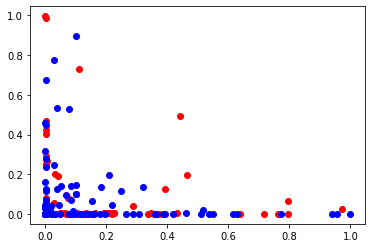

In [112]:
vectors_10 = lda.transform(count_data)

# Plot
plt.scatter(vectors_10[:100, 0], vectors_10[:100, 1], color = "red")
plt.scatter(vectors_10[5000:, 0], vectors_10[5000:, 1], color = "blue")
plt.show()

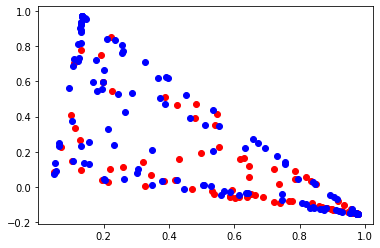

In [113]:
svd = TruncatedSVD(2)
vectors_2 = svd.fit_transform(vectors_10)

# Plot
plt.scatter(vectors_2[:100, 0], vectors_2[:100, 1], color = "red")
plt.scatter(vectors_2[5000:, 0], vectors_2[5000:, 1], color = "blue")
plt.show()

### Using Doc2Vec

In [114]:
documents = [TaggedDocument(doc.split(" "), [i]) for i, doc in enumerate(df_songs["Lyrics"].fillna(""))]
model = Doc2Vec(documents, vector_size=300, window=4, min_count=1, workers=4, epochs=10, dbow_words=1)

sentence = "I cant get no satisfaction"
vector = model.infer_vector(sentence.split(" "))
documents[model.docvecs.most_similar([vector])[1][0]]

TaggedDocument(words=['I', "can't", 'get', 'no', 'satisfaction', 'I', "can't", 'get', 'no', 'satisfaction', 'Cause', 'I', 'try', 'and', 'I', 'try', 'and', 'I', 'try', 'and', 'I', 'try', 'I', "can't", 'get', 'no,', 'I', "can't", 'get', 'no', '', 'When', "I'm", 'driving', 'in', 'my', 'car', 'And', 'that', 'man', 'comes', 'on', 'the', 'radio', 'And', "he's", 'telling', 'me', 'more', 'and', 'more', 'About', 'some', 'useless', 'information', 'Supposed', 'to', 'fire', 'my', 'imagination', 'I', "can't", 'get', 'no,', 'oh', 'no,', 'no,', 'no!', 'Hey,', 'hey,', 'hey!', "That's", 'what', "I'll", 'say!', '', 'I', "can't", 'get', 'no', 'satisfaction', 'I', "can't", 'get', 'no', 'satisfaction', "'Cause", 'I', 'try,', 'and', 'I', 'try,', 'and', 'I', 'try,', 'and', 'I', 'try', 'I', "can't", 'get', 'no,', 'I', "can't", 'get', 'no', '', 'When', "I'm", 'watching', 'my', 'TV', 'And', 'a', 'man', 'comes', 'on', 'and', 'tells', 'me', 'How', 'white', 'my', 'shirts', 'can', 'be', 'Well', 'he', "can't", 'be',

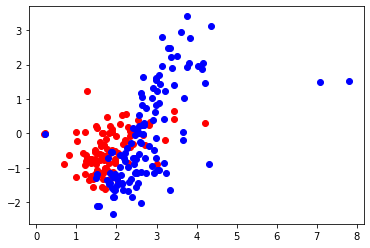

In [115]:
svd = TruncatedSVD(2)
vectors_2 = svd.fit_transform(model.docvecs.vectors_docs)

# Plot
plt.scatter(vectors_2[:100, 0], vectors_2[:100, 1], color = "red")
plt.scatter(vectors_2[5000:, 0], vectors_2[5000:, 1], color = "blue")
plt.show()

# Events

In [116]:
import re
import spacy
import pandas as pd
from spacy import displacy

In [117]:
data_file = "datasets/events/events_full.csv"
df_events = pd.read_csv(data_file, index_col=0, header=0, sep=",")
df_events.head()

,Year,Month,Day,Content,Wikipedia,Summary
0,1965,January,30,State Funeral of Winston Churchill at St Paul'...,https://en.wikipedia.org/wiki/Death_and_state_...,"Sir Winston Churchill died on 24 January 1965,..."
1,1965,March,18,"Cosmonaut Alexey Leonov, leaving his spacecraf...",https://en.wikipedia.org/wiki/Voskhod_2,"Voskhod 2 (Russian: Восход-2, lit. 'Sunrise-2'..."
2,1965,March,22,US confirms its troops used chemical warfare a...,https://en.wikipedia.org/wiki/People%27s_Army_...,The People's Army of Vietnam (PAVN; Vietnamese...
3,1965,May,5,First large-scale US Army ground units arrive ...,https://en.wikipedia.org/wiki/Military_history...,Australia's involvement in the Vietnam War beg...
4,1965,June,7,The Supreme Court of the United States decides...,https://en.wikipedia.org/wiki/Roe_v._Wade,"Roe v. Wade, 410 U.S. 113 (1973), was a landma..."


In [118]:
def entity_extractor(cols, song = False):
    
    # Parametrable extraction
    ignore_entities = ["CARDINAL", "MONEY", "ORDINAL", "QUANTITY", "TIME"]
    nlp = spacy.load("en_core_web_md")
    
    def extract_entities(row):
        
        # Actual extraction
        entities = []
        for col in cols:
            if type(row[col]) == str:
                entities += [(ent.text, ent.label_) for ent in nlp(row[col]).ents if ent.label_ not in ignore_entities]
                
        if song : 
            entities.append((row["Artist"], "PERSON"))
            entities.append((row["Song"], "WORK_OF_ART"))
            entities.append((row["Album"], "WORK_OF_ART"))
        
        return entities
    
    return extract_entities

In [119]:
extraction_cols = ["Content", "Summary"]
df_songs["Entities"] = df_songs.apply(entity_extractor(["Lyrics"]), axis = 1)
df_events["Entities"] = df_events.apply(entity_extractor(extraction_cols), axis = 1)

<AxesSubplot:>

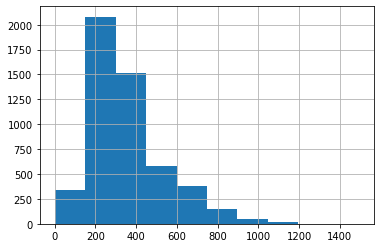

In [120]:
df_songs["word_count"] = df_songs["Lyrics"].apply(lambda x : len(x.split(" ")))
df_songs["word_count"].hist()

In [121]:
def getStartEnd_entities(row, events = False):
    occurences = []
    col = "Summary" if events else "Lyrics"
    for ent, ent_type in set(row["Entities"]):
        try:
            occurences += [(ent, ent_type, m.start(), m.end()) for m in re.finditer(ent, row[col])]
        except:
            ent = re.sub('([\[\].,!?()\*])', r'', ent)
            occurences += [(ent, ent_type, m.start(), m.end())
                           for m in re.finditer(ent, row[col])]
    return sorted(occurences, key=lambda x : x[2])

In [122]:
def choseEntity(row):
    prev_end = 0
    filteredEnts = []
    for ent, ent_type, start, end in row["Entities_more"]:
        if prev_end > start:
            # Entities are overlapping, forget this one
            continue
        filteredEnts.append((ent, ent_type, start, end))
        prev_end = end
    return filteredEnts

In [123]:
df_songs["Entities_more"] = df_songs.apply(getStartEnd_entities, axis = 1)
df_songs["Entities_more"] = df_songs.apply(choseEntity, axis = 1)

df_events["Entities_more"] = df_events.apply(lambda row: getStartEnd_entities(row, events=True), axis = 1)
df_events["Entities_more"] = df_events.apply(choseEntity, axis = 1)

In [124]:
def find_refs(song_rows):
    refs = []
    for entity, label in song_rows["Entities"]:
        entity = entity.lower()
        for i, row in df_events["Entities"].iteritems():
            ents_lower = [ent.lower() for ent, lab in row]
            if any([entity.lower() in low_ent or low_ent in entity for low_ent in ents_lower]):
                refs.append(i)
    return refs

In [125]:
# Add references to events in songs
df_songs["Refs"] = df_songs.apply(find_refs, axis = 1)
df_songs["Refs"] = df_songs["Refs"].apply(set)

In [127]:
# Add references to songs in events
df_events["Refs"] = [[] for i in range(len(df_events))]
for i_song, refs in df_songs["Refs"].iteritems():
    for i_event in refs:
        df_events.iloc[i_event]["Refs"].append(i_song)
        
df_events["Refs"] = df_events["Refs"].apply(set)

In [ ]:
s = dict()
for ents in df_songs["Entities"].apply(lambda x : [e[0] for e in x]).values:
    for ent in ents :
        if ent in s:
            s[ent] +=1
        else :
            s[ent] = 1
            
s = {k: v for k, v in sorted(s.items(), key=lambda item: item[1], reverse=True)}

# Display all the types of entities recognized
ent_types = set()
for s in df_songs["Entities"].apply(lambda x : set([e[1] for e in x])):
    for ent in s:
        ent_types.add(ent)

ent_types

In [ ]:
# df.to_csv("songs_with_refs.csv")
# df_events.to_csv("events_with_refs.csv")

# with open("datasets/songs_with_refs.pickle", "wb") as f :
#     pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)
    
# with open("datasets/events_with_refs.pickle", "wb") as f :
#     pickle.dump(df_events, f, pickle.HIGHEST_PROTOCOL)

# Using the references

In [ ]:
with open("datasets/songs_with_refs.pickle", "rb") as f :
    df_songs = pickle.load(f)
    
with open("datasets/events_with_refs.pickle", "rb") as f :
    df_events = pickle.load(f)

In [ ]:
all_docs = np.concatenate((df_songs["Lyrics"].fillna(""), df_events["Content"].fillna("")))
documents = [TaggedDocument(doc.split(" "), [i]) for i, doc in enumerate(all_docs)]
model = Doc2Vec(documents, vector_size=300, window=4, min_count=1, workers=4, epochs=10, dbow_words=1)

In [ ]:
lyrics2events_sim = []
for i in range(len(df)):
    sims = model.docvecs.most_similar(positive=[model.docvecs[i]], topn=100, clip_start=len(df))[1:]
    sims = [x for x in sims if (x[0] - len(df)) in df.xs(i)["Refs"]]
    sims_refs = sorted(sims, key = lambda x : x[1], reverse=True)[:10]
    lyrics2events_sim.append(sims_refs)

df_songs["Similar"] = lyrics2events_sim
df_songs[df_songs["Similar"].apply(len) > 0].head()

# BERT

In [ ]:
import torch
from tqdm import tqdm_notebook
from transformers import AlbertModel, AlbertTokenizer

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')
model = AlbertModel.from_pretrained('albert-large-v2')

In [ ]:
if torch.cuda.is_available():  
    dev = "cuda:0"
    model.cuda()
else:  
    dev = "cpu"  
device = torch.device(dev)  
None

### Vectorize lyrics

In [ ]:
df_songs["word_count"] = df_songs["Lyrics"].apply(lambda x : len(x.split(" ")))
lyrics_tokenized = torch.Tensor(tokenizer.batch_encode_plus(df_songs["Lyrics"],
                                                            max_length=512,
                                                            pad_to_max_length=True,
                                                            padding_side="right",
                                                            add_special_tokens=True)["input_ids"]).long()
lyrics_vectorized = []
batch_size = 8
with torch.no_grad():
    for i in range(0, len(df), batch_size):
        batch = lyrics_tokenized[i: min(i + batch_size, len(df_songs))].to(device)
        lyrics_vectorized.append(model(batch)[1].tolist())
        del batch
        torch.cuda.empty_cache()
        
lyrics_vectors = []
for batch_lyrics in lyrics_vectorized:
    for lyric in batch_lyrics:
        lyrics_vectors.append(lyric)
        
df_songs["vect"] = lyrics_vectors

### Vectorize events

In [ ]:
df_events["text_vect"] = df_events["Summary"].fillna(df_events.Content)
df_events["word_count"] = df_events["text_vect"].apply(lambda x : len(x.split(" ")))
df_events["text_vect"] = np.where(df_events["word_count"] > 320, df_events["Content"], df_events["text_vect"])
df_events["word_count"] = df_events["text_vect"].apply(lambda x : len(x.split(" ")))

events_tokenized = torch.Tensor(tokenizer.batch_encode_plus(df_events.text_vect,
                                                            max_length =512,
                                                            pad_to_max_length=True,
                                                            padding_side = "right",
                                                            add_special_tokens=True)["input_ids"]).long()

events_vectorized = []
batch_size = 8
with torch.no_grad():
    for i in tqdm_notebook(range(0, len(df_events), batch_size)):
        batch = events_tokenized[i: min(i + batch_size, len(df_events))].to(device)
        events_vectorized.append(model(batch)[1].tolist())
        del batch
        torch.cuda.empty_cache()
        
events_vectors = []
for batch_events in events_vectorized:
    for event in batch_events:
        events_vectors.append(event)
        
df_events["vect"] = events_vectors

# Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
sim = cosine_similarity(df_songs["vect"].tolist(), df_events["vect"].tolist())

In [ ]:
df_songs["filteredRefs"].apply(len).hist()

In [ ]:
def filterRefs(row):
    filteredRefs = []
    for ref in row["Refs"]:
        if row["sims"][ref] > 0.94:
            filteredRefs.append(ref)
    return filteredRefs

In [ ]:
df_songs["filteredRefs"] = df_songs.apply(filterRefs, axis = 1)

In [ ]:
# Add references to songs in events
df_events["filteredRefs"] = [[] for i in range(len(df_events))]
for i_song, refs in df_songs["filteredRefs"].iteritems():
    for i_event in refs:
        df_events.iloc[i_event]["filteredRefs"].append(i_song)
        
df_events["filteredRefs"] = df_events["filteredRefs"].apply(set)

In [ ]:
df_events["Entities"].apply(lambda l : [x[0] for x in l])
df_events["Ents"] = df_events["Entities"].apply(lambda l : [x[0] for x in l])
df_events["Ents_types"] = df_events["Entities"].apply(lambda l : [x[1] for x in l])

In [ ]:
df_songs["Ents"] = df["Entities"].apply(lambda l : [x[0] for x in l])
df_songs["Ents_types"] = df["Entities"].apply(lambda l : [x[1] for x in l])

## Save to csv for Website

In [ ]:
df_events["num_refs"] = df_events["filteredRefs"].apply(len)
df_songs["num_refs"] = df_songs["filteredRefs"].apply(len)

In [ ]:
def entities_embedding(row, songs = False):
    col = "Lyrics_print" if songs else "Summary"
    
    color = "#ffffff" if songs else "#f28e61"
    text_color = "color : #ffffff;" if not songs else ""
    
    if len(row["Entities_more"]) == 0:
        return row[col]
    
    s = ""
    original = row[col]
    prev_end = 0
    for ent, ent_type, start, end in row["Entities_more"]:
        s += original[prev_end : start]
        embedded_entity = ("<mark class=\"entity\" style=\"background: %s;%s padding: 0.05em 0.05em; margin: 0 0.15em;"
        "line-height: 1; border-radius: 0.35em;\">%s"
        "<span style=\"font-size: 0.5em; font-weight: bold;%s line-height: 1; border-radius: 0.35em; text-transform: uppercase;"
        "vertical-align: middle; margin-left: 0.25rem; margin-bottom:0.25rem\">%s</span></mark>""") % (color, text_color, ent, text_color, ent_type)
        s += embedded_entity
        prev_end = end
    s+=original[prev_end :]
    
    return s

### Extra refs

In [ ]:
for i_event, event in df_events.iterrows():
    for i_music, music in df_songs.iterrows():
        trigger_values = [music["Song"].lower(), music["Album"].lower()] + music["Artist"].lower().split("and")
        for value in trigger_values:
            if value in event["Content"].lower() or value in event["Summary"].lower():
                event["filteredRefs"].add(i_music)
                music["filteredRefs"].add(i_event)

In [ ]:
df_events["Summary_embedded"] = df_events.apply(entities_embedding, axis = 1)
df_events.drop(columns = ["vect", "Refs", "Entities", "word_count", "text_vect"])\
    .to_csv("datasets/events_refs_website.csv")
df_events["num_refs"] = df_events["filteredRefs"].apply(len)

df_songs["Lyrics_print_embedded"] = df_songs.apply(entities_embedding, axis = 1)
df_songs.drop(columns = ["vect", "sims", "Refs", "word_count", "Entities", "Lyrics"]).rename(columns = {"Lyrics_display": "Lyrics"})\
    .to_csv("datasets/songs_refs_website.csv")
df_songs["num_refs"] = df["filteredRefs"].apply(len)

In [ ]:
df_events[["Year", "Month", "Day", "Content", "Wikipedia", "Summary", "Entities", "filteredRefs", "num_refs"]]\
    .to_json("events_refs_final.json")
df_events[["Year", "Month", "Day", "Content", "Wikipedia", "Summary", "Entities", "filteredRefs", "num_refs"]]\
    .to_csv("events_refs_final.csv")

In [ ]:
df_song["num_refs"] = df["filteredRefs"].apply(len)
df_events["num_refs"] = df_events["filteredRefs"].apply(len)
df_songs[df_songs["filteredRefs"].apply(len) == 0]["Year"].hist()

In [ ]:
print(df_events["filteredRefs"].apply(len).max())
print(df_events["filteredRefs"].apply(len).mean())
print(df_events["Refs"].apply(len).max())
print(df_events["Refs"].apply(len).mean())

In [ ]:
print(df_songs["filteredRefs"].apply(len).max())
print(df_songs["filteredRefs"].apply(len).mean())
print(df_songs["Refs"].apply(len).max())
print(df_songs["Refs"].apply(len).mean())

In [ ]:
with open("events_vects.pickle", "rb") as f:
    tmp = pickle.load(f)
with open("events_vects.pickle", "wb") as f:
    pickle.dump(events_vectorized, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
events_vectorized = []
batch_size = 8
with torch.no_grad():
    for i in range(0, len(df_events), batch_size):
        batch = events_tokenized[i: min(i + batch_size, len(df_events))].to(device)
        events_vectorized.append(model(batch))
        del batch
        
events_vectorized = [x[1] for x in events_vectorized]

In [ ]:
events_vectors = []
for batch_event in events_vectorized:
    for event in batch_event:
        events_vectors.append(event.tolist())
        
df_events["vect"] = events_vectors

In [ ]:
tmp = [sent for sent in df_events["text_vect"]]
x = torch.tensor(tmp)

## Export tsv

In [ ]:
pd.DataFrame(model.docvecs.vectors_docs).to_csv("vec.tsv", index=False, sep="\t", header=False)

In [ ]:
df_song.to_csv("data.tsv", sep="\t", index=False)